<a href="https://colab.research.google.com/github/Se1towo/Game-Project-Group-16-/blob/main/IMLO_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Keras                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Activation                          # Layer for activation functions
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from keras.models import load_model                          # This helps us to load trained models

# Importing TensorFlow
import tensorflow as tf

In [ ]:
seed = 123

In [ ]:
# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print('\nGPU Found! Using GPU...')
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [ ]:
# Giving names to each directory
directories = {
    train_dir: 'data/',
    test_dir: 'Test',
    val_dir: 'Validation'
    }

# Naming subfolders
subfolders = ['Healthy', 'Powdery', 'Rust']

print('\n* * * * * Number of files in each folder * * * * *\n')

# Counting the total of pictures inside each subfolder and directory
for dir, name in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
# Initiating model on GPU
with strategy.scope():
    model = Sequential()

    model.add(augmentation) # Adding data augmentation pipeline to the model

    # Feature Learning Layers
    model.add(Conv2D(32,                  # Number of filters/Kernels
                     (3,3),               # Size of kernels (3x3 matrix)
                     strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                     padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input.
                    input_shape = (256,256,3) # Input image shape
                    ))
    model.add(Activation('relu'))# Activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    # Flattening tensors
    model.add(Flatten())

    # Fully-Connected Layers
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(3, activation = 'softmax')) # Classification layer

In [1]:
##########################################

In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import scipy.io
import csv

In [3]:
plt.style.use('ggplot')

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, loss_fn
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, 'outputs/best_model.pth')

In [4]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/final_model.pth')

In [5]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/accuracy.png')

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.png')

In [6]:
learning_rate = 1e-3
batch_size = 64
epochs = 1

In [7]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
training_data = datasets.Flowers102(
    root="data",
    split="train",
    download=True,
    transform=transform
)
print("Training data:", training_data)

test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform=transform
)
print("Testing data:", test_data)

validation_data = datasets.Flowers102(
    root="data",
    split="val",
    download=True,
    transform=transform
)
print("Validation data:", validation_data)

Training data: Dataset Flowers102
    Number of datapoints: 1020
    Root location: data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Testing data: Dataset Flowers102
    Number of datapoints: 6149
    Root location: data
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Validation data: Dataset Flowers102
    Number of datapoints: 1020
    Root location: data
    split=val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               

In [10]:
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size, shuffle=True)

In [11]:
train_dataset_size = len(training_data)

<ipython-input-12-8f16292b5e7b>:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  plt.imshow(img.squeeze().T)


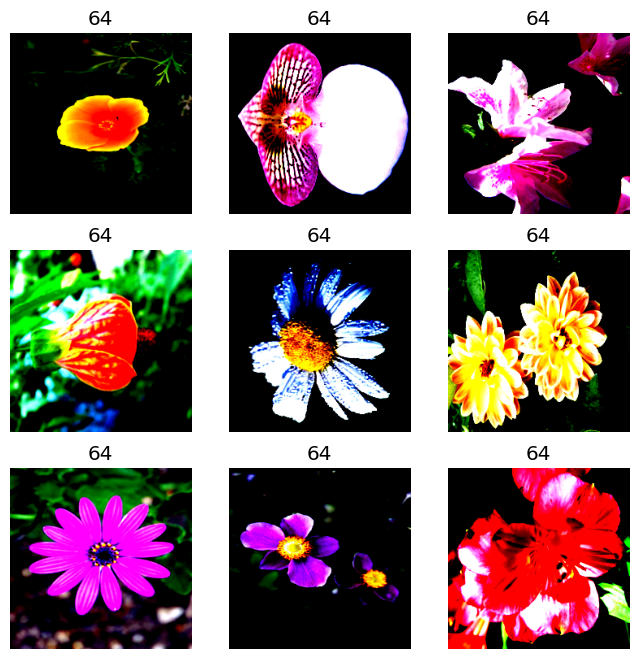

In [12]:
# 9 sample images from training dataset
labels_map = {}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    if label not in labels_map:
      labels_map[label] = img
    figure.add_subplot(rows, cols, i)
    plt.title(list(labels_map.keys())[i % len(labels_map)]) #works when rerun
    plt.axis("off")
    plt.imshow(img.squeeze().T)
plt.show()

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


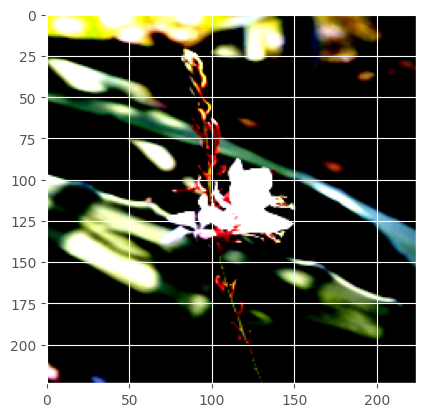

Label: 56


In [13]:
# Example training image
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].T.squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [15]:
#import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_pooling_stack = nn.Sequential(
            # Convolutional Layer
            nn.Conv2d(in_channels=3, out_channels=102, kernel_size=11, stride=4, padding=2),
            # Batch Normalization
            nn.BatchNorm2d(102),
            # Activation Layer
            nn.ReLU(inplace=True),
            # Pooling Layer
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(102, 256, kernel_size=5, padding=2),
            # Batch Normalization
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            # # Batch Normalization
            # nn.BatchNorm2d(384),
            # nn.LeakyReLU(inplace=True),
            # nn.Conv2d(384, 384, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(384),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(384),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(384),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            # Fully connected layers
            nn.Linear(256 * 6 * 6, 4096),
            nn.LeakyReLU(inplace=True),
            # Regularization
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # Regularization
            nn.Dropout(),
            nn.Linear(4096, 102),
        )

    def forward(self, x):
        x = self.conv_pooling_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [16]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv_pooling_stack): Sequential(
    (0): Conv2d(3, 102, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(102, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [17]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (conv_pooling_stack): Sequential(
    (0): Conv2d(3, 102, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(102, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_run

In [23]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        correct += (pred.argmax(1) == y).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_accuracy = 100.0 * correct / size
    print(f"Training Accuracy: {train_accuracy:.2f}%\n")
    return loss, train_accuracy


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).sum().item()

    test_loss /= size
    test_accuracy = 100.0 * correct / size
    print(f"Testing Error: \n Accuracy: {test_accuracy:>0.2f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, test_accuracy

In [ ]:
epochs = 100

Epoch 1
-------------------------------
Training loss: 4.534881  [   64/ 1020]
Training Accuracy: 1.96%

Testing Error: 
 Accuracy: 3.94%, Avg loss: 0.072246 


Best validation loss: 0.07224614726060541

Saving best model for epoch: 1

Epoch 2
-------------------------------
Training loss: 4.508888  [   64/ 1020]
Training Accuracy: 2.55%

Testing Error: 
 Accuracy: 4.28%, Avg loss: 0.072167 


Best validation loss: 0.07216686364169392

Saving best model for epoch: 2

Epoch 3
-------------------------------
Training loss: 4.532512  [   64/ 1020]
Training Accuracy: 3.53%

Testing Error: 
 Accuracy: 4.36%, Avg loss: 0.072053 


Best validation loss: 0.07205297749572545

Saving best model for epoch: 3

Epoch 4
-------------------------------
Training loss: 4.533438  [   64/ 1020]
Training Accuracy: 4.41%

Testing Error: 
 Accuracy: 4.28%, Avg loss: 0.071940 


Best validation loss: 0.07193992738511276

Saving best model for epoch: 4

Epoch 5
-------------------------------
Training loss: 4

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

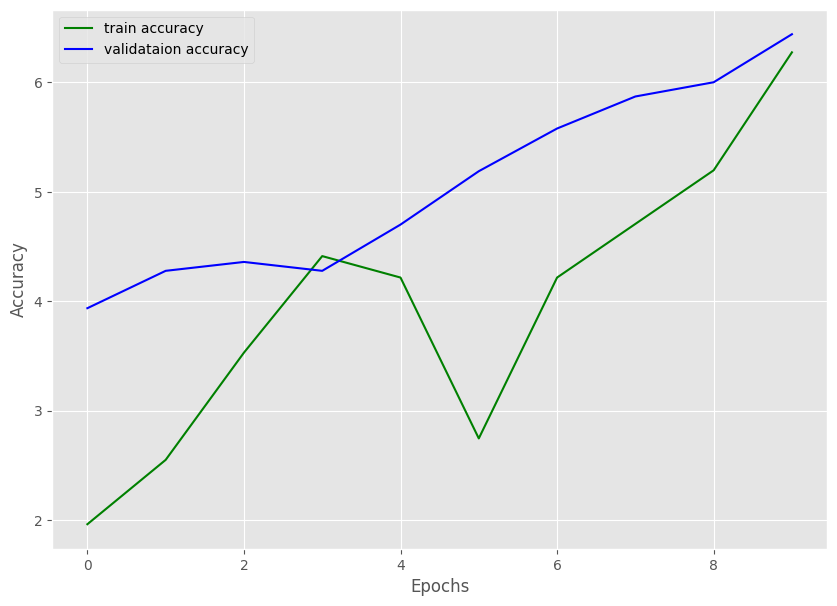

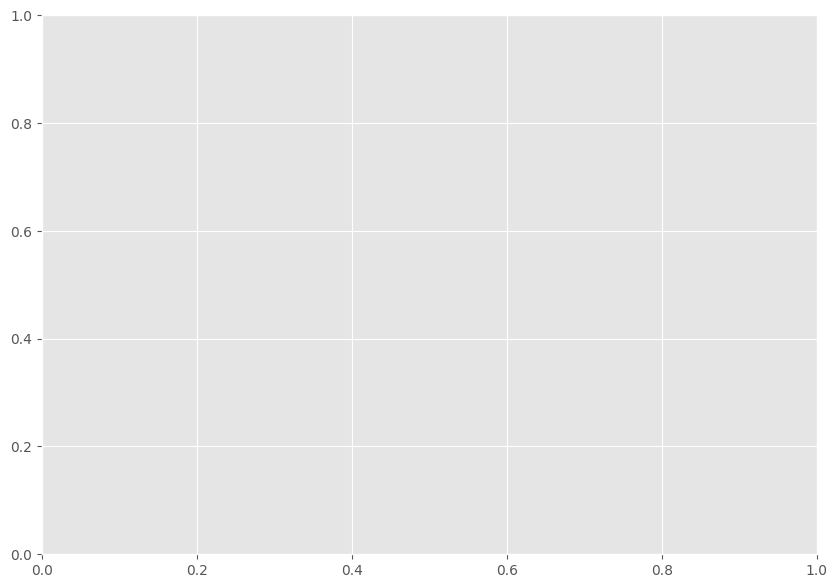

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
save_best_model = SaveBestModel()

# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(test_loss, t, model, optimizer, loss_fn)
    train_loss.append(loss)
    valid_loss.append(test_loss)
    train_acc.append(train_accuracy)
    valid_acc.append(test_accuracy)
# save the trained model weights for a final time
save_model(epochs, model, optimizer, loss_fn)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print("Done!")

In [ ]:
print(type(train_loss))
print(type(valid_loss))

In [ ]:
# plt.plot(np.array(train_loss), 'r')
# plt.plot(np.array(valid_loss), 'b')
# plt.title("Training vs Testing loss")
# plt.show()
# plt.plot(np.array(train_acc), 'r')
# plt.plot(np.array(valid_acc), 'b')
# plt.title("Training vs Testing accuracy")
# plt.show()

In [ ]:
#Testing best model

# build the model, no need to load the pre-trained weights or fine-tune layers
model = NeuralNetwork().to(device)
# load the best model checkpoint
best_model_cp = torch.load('outputs/best_model.pth')
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")
# load the last model checkpoint
last_model_cp = torch.load('outputs/final_model.pth')
last_model_epoch = last_model_cp['epoch']
print(f"Last model was saved at {last_model_epoch} epochs\n")
# get the test dataset and the test data loader
training_data = datasets.Flowers102(
    root="data",
    split="train",
    download=True,
    transform=transform
)

test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform=transform
)

validation_data = datasets.Flowers102(
    root="data",
    split="validation",
    download=True,
    transform=transform
)
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size, shuffle=True)

In [ ]:
def test(model, testloader):
    """
    Function to test the model
    """
    # set model to evaluation mode
    model.eval()
    print('Testing')
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # loss and accuracy for the complete epoch
    final_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return final_acc
# test the last epoch saved model
def test_last_model(model, checkpoint, test_loader):
    print('Loading last epoch saved model weights...')
    model.load_state_dict(checkpoint['model_state_dict'])
    test_acc = test(model, test_loader)
    model.summary()
    print(f"Last epoch saved model accuracy: {test_acc:.3f}")
# test the best epoch saved model
def test_best_model(model, checkpoint, test_loader):
    print('Loading best epoch saved model weights...')
    model.load_state_dict(checkpoint['model_state_dict'])
    test_acc = test(model, test_loader)
    model.summary()
    print(f"Best epoch saved model accuracy: {test_acc:.3f}")

In [ ]:
test_last_model(model, last_model_cp, validation_dataloader)
test_best_model(model, best_model_cp, validation_dataloader)